In [494]:
from statsbombpy import sb
import pandas as pd
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch, add_image,Pitch
import matplotlib.pyplot as pltma
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as font_manager
from scipy.ndimage import gaussian_filter
from matplotlib import patches
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tqdm
from matplotlib.lines import Line2D
import warnings
import os
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
from socceraction.data.statsbomb import StatsBombLoader
import sqlite3
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import json

In [789]:
import pandas as pd
import os

# Define the path to the file in the Downloads folder
downloads_folder = os.path.expanduser("~/Downloads")
file_path = os.path.join(downloads_folder, "3943043.json")

# Load the JSON file into a DataFrame
df = pd.read_json(file_path)
df['type_name'] = df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
df['team_name'] = df['team'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
df['player_name'] = df['player'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
df['x'] = df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
df['y'] = df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

In [312]:
# Field tilt

In [294]:
def game_flow(df, ax, focus_team, opposition, focus_color='blue', oppo_color='red'):
    # Extract event type names
    df = df.copy()  # Avoid modifying original DataFrame
    df['type_name'] = df['type'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)

    # Sort by period and minute
    df = df.sort_values(by=['period', 'minute'])

    # Group minutes into 5-minute intervals
    df['grouped_min'] = (df['minute'] // 5) * 5
    max_minute = df['minute'].max()
    valid_minutes = list(range(5, max_minute + 5, 5))
    df = df[df['grouped_min'].isin(valid_minutes)]

    # Filter for relevant events
    poss = df[df['type_name'].isin(['Pass', 'Carry', 'Shot', 'Dribble'])].copy()

    # Ensure 'pass' column exists before filtering
    if 'pass' in poss.columns:
        poss = poss[poss['pass'].isna()]

    # Extract x coordinate from location
    poss['x'] = poss['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    
    # Keep only events in the attacking half (x >= 80)
    poss = poss[poss['x'] >= 80]

    # Separate team possessions
    teamposs = poss[poss["team_name"] == focus_team].copy()
    oppoposs = poss[poss["team_name"] == opposition].copy()

    # Group by 'grouped_min'
    teamPOSSlist = teamposs.groupby(['grouped_min']).size().reset_index(name="team_poss")
    oppoPOSSlist = oppoposs.groupby(['grouped_min']).size().reset_index(name="oppo_poss")

    # Merge possession lists
    matchposs = pd.merge(teamPOSSlist, oppoPOSSlist, how="outer", on=["grouped_min"]).fillna(0)

    # Time intervals
    timelist = sorted(matchposs["grouped_min"].tolist())
    teamPOSSlist = matchposs["team_poss"].tolist()
    oppoPOSSlist = matchposs["oppo_poss"].tolist()

    # Compute field tilt
    poss_difflist = np.array(teamPOSSlist) - np.array(oppoPOSSlist)
    poss_difflist = gaussian_filter1d(poss_difflist, sigma=1)

    # Plot goals

    # Filter for team goals (focus team)
    team_goals = df[
        ((df["team_name"] == focus_team) & (df["type_name"] == "Shot") & 
         (df["shot"].apply(lambda x: isinstance(x, dict) and x.get('outcome', {}).get('name', '') == "Goal"))) |
        ((df["type_name"] == "Own Goal For") & (df["team_name"] == focus_team))
    ]
    
    # Filter for opposition goals
    oppo_goals = df[
        ((df["team_name"] == opposition) & (df["type_name"] == "Shot") & 
         (df["shot"].apply(lambda x: isinstance(x, dict) and x.get('outcome', {}).get('name', '') == "Goal"))) |
        ((df["type_name"] == "Own Goal For") & (df["team_name"] == opposition))
    ]
    
    # Plot goals for the focus team
    ax.scatter('minute', range(len(team_goals)), data=team_goals,
               color=focus_color, ec="white", lw=3, hatch="///",
               marker='o', s=750, zorder=12, label=f"{focus_team} goals")
    
    # Plot goals for the opposition
    oppo_end = len(oppo_goals) * -1
    ax.scatter('minute', range(oppo_end, 0), data=oppo_goals,
               color=oppo_color, ec="black", lw=3, hatch="///",
               marker='o', s=750, zorder=12, label=f"{opposition} goals")


    ax.set_facecolor('white')
    ax.plot(timelist, poss_difflist, 'lightgrey')

    y1positive = poss_difflist >= 0
    y1negative = poss_difflist < 0

    ax.set_yticks([])
    ax.yaxis.label.set_color("black")
    ax.tick_params(axis='y', colors="black")

    ax.fill_between(timelist, poss_difflist, where=y1positive, color=focus_color, alpha=0.95, interpolate=True)
    ax.fill_between(timelist, poss_difflist, where=y1negative, color=oppo_color, alpha=0.95, interpolate=True)

    ax.set_xticks(range(0, int(df['minute'].max()) + 1, 10))
    ax.set_yticks(range(-20, 21, 5))
    ax.set_yticklabels([f"{tick}" for tick in range(-20, 21, 5)], fontsize=12)
    ax.grid(False)
    ax.legend(fontsize=18, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_ylabel("Field Tilt", fontsize=26, color="black")
    ax.set_ylim(-25, 25)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # Compute possession percentages
    totalfocus = len(teamposs)
    totaloppo = len(oppoposs)
    total = len(poss)

    percentfocus = round(totalfocus / total * 100, 1) if total > 0 else 0
    percentoppo = round(totaloppo / total * 100, 1) if total > 0 else 0

    # Add title
    ax.set_title("Field Tilt", fontsize=30, fontweight='bold', color="black", y=1.15)

    fig.text(s="Field tilt is the share of touches in the final third. Using a 5 Minute Moving Average.",
        x=0.125, y=0.95, fontsize=18)

    ax.text(0, 26, f"{opposition} Share: {totaloppo} ({percentoppo}%)", fontsize=23, ha="left", weight="bold", color=oppo_color)
    ax.text(0, 22, f"{focus_team} Share: {totalfocus} ({percentfocus}%)", fontsize=23, ha="left", weight="bold", color=focus_color)

In [295]:
focus_team = "England" 
opposition = "Spain"  

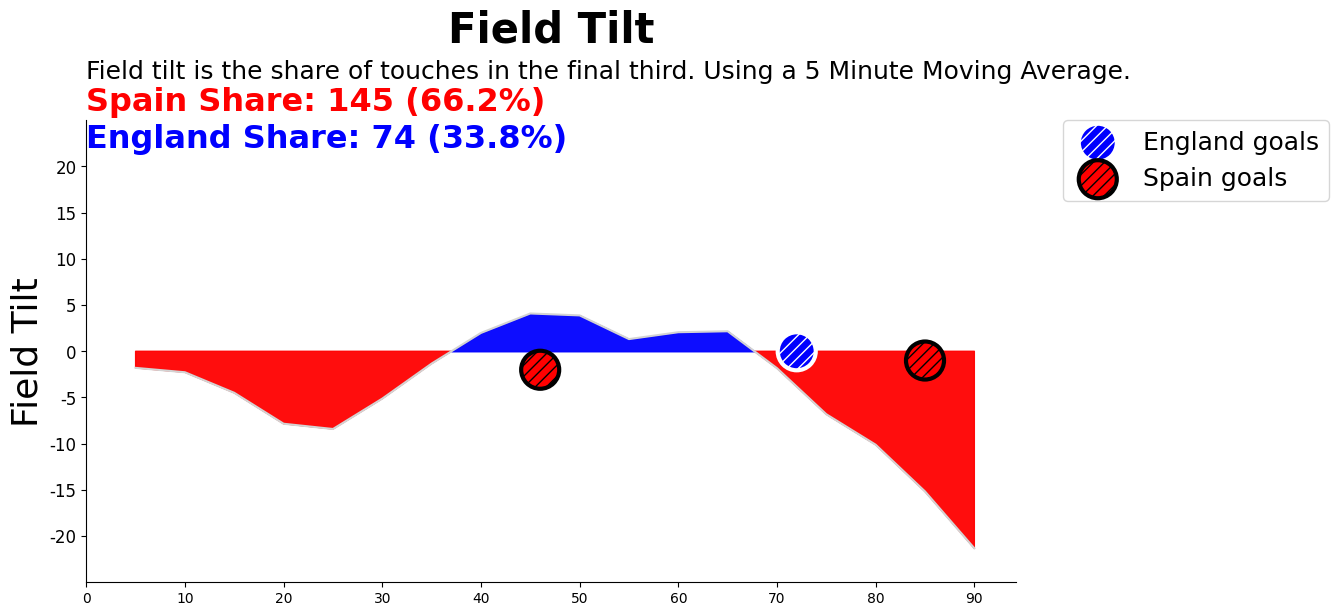

In [296]:
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust size if needed
game_flow(df, ax, focus_team, opposition, focus_color='blue', oppo_color='red')
output_path = f"/Users/andreasbancheri/Documents/Tottenham/fieldtilt.png"  # Adjust the path and filename as needed
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()  # Display the plot

In [311]:
#xG Race Chart

In [309]:
def plot_xg_race(df, focus_team, opposition, focus_color='blue', oppo_color='red', focus_score=2, oppo_score=1):
    # Extract relevant shot data (xG and minute)
    shots = df[df["type_name"] == "Shot"].copy()

    # Ensure the 'shot' column is a dictionary and extract xG and shot time (minute)
    shots['xg'] = shots['shot'].apply(lambda x: x.get('statsbomb_xg', 0) if isinstance(x, dict) else 0)
    shots['minute'] = shots['minute'].astype(int)

    # Filter shots for each team
    focus_shots = shots[shots["team_name"] == focus_team]
    oppo_shots = shots[shots["team_name"] == opposition]

    # Sort shots by time (minute)
    focus_shots = focus_shots.sort_values(by='minute')
    oppo_shots = oppo_shots.sort_values(by='minute')

    # Calculate cumulative xG for each team
    focus_shots['cumulative_xg'] = focus_shots['xg'].cumsum()
    oppo_shots['cumulative_xg'] = oppo_shots['xg'].cumsum()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the xG race for focus team
    prev_minute = 0
    prev_xg = 0
    for i, row in focus_shots.iterrows():
        ax.plot([prev_minute, row['minute']], [prev_xg, prev_xg], color=focus_color, linewidth=3)  # horizontal line
        ax.plot([row['minute'], row['minute']], [prev_xg, row['cumulative_xg']], color=focus_color, linewidth=3)  # vertical line
        prev_minute = row['minute']
        prev_xg = row['cumulative_xg']

    # Plot the xG race for opposition
    prev_minute = 0
    prev_xg = 0
    for i, row in oppo_shots.iterrows():
        ax.plot([prev_minute, row['minute']], [prev_xg, prev_xg], color=oppo_color, linewidth=3)  # horizontal line
        ax.plot([row['minute'], row['minute']], [prev_xg, row['cumulative_xg']], color=oppo_color, linewidth=3)  # vertical line
        prev_minute = row['minute']
        prev_xg = row['cumulative_xg']

    # Add markers for each shot
    ax.scatter(focus_shots['minute'], focus_shots['cumulative_xg'], color=focus_color, label=f"{focus_team} xG", zorder=10, s=100, marker='|')
    ax.scatter(oppo_shots['minute'], oppo_shots['cumulative_xg'], color=oppo_color, label=f"{opposition} xG", zorder=10, s=100, marker='|')

    # Add graphic for the final cumulative xG
    # Focus team final xG
    ax.text(focus_shots['minute'].iloc[-1] + 1, focus_shots['cumulative_xg'].iloc[-1], 
            f"{focus_shots['cumulative_xg'].iloc[-1]:.2f}", color=focus_color, fontsize=12, ha='left', va='center', fontweight='bold')
    # Opposition final xG
    ax.text(oppo_shots['minute'].iloc[-1] + 1, oppo_shots['cumulative_xg'].iloc[-1], 
            f"{oppo_shots['cumulative_xg'].iloc[-1]:.2f}", color=oppo_color, fontsize=12, ha='left', va='center', fontweight='bold')

    # Set labels
    ax.set_xlabel('Minute', fontsize=14)
    ax.set_ylabel('Cumulative xG', fontsize=14)

    # Custom title with score in different colors using ax.text()
    ax.text(0.4, 1.05, f"{focus_team} 2", color=focus_color, fontsize=24, ha='center', va='bottom', transform=ax.transAxes, fontweight='bold')
    ax.text(0.5, 1.05, f"-", fontsize=24, ha='center', va='bottom', transform=ax.transAxes, fontweight='bold')
    ax.text(0.58, 1.05, f"1 {opposition}", color=oppo_color, fontsize=24, ha='center', va='bottom', transform=ax.transAxes, fontweight='bold')
    ax.text(0.5, 1.01, f"xG Race Chart", fontsize=12, ha='center', va='bottom', transform=ax.transAxes)

    # Set x-axis limits
    ax.set_xlim(0, max(df['minute']) + 10)
    ax.set_xticks(range(0, max(df['minute']) + 10, 5))

    # Remove grid lines
    ax.grid(True)
    
    # Add legend with bold font
    ax.legend(loc='upper left', prop={'weight': 'bold'})

    # Show the plot
    plt.tight_layout()

    output_path = f"/Users/andreasbancheri/Documents/Tottenham/xg_racechart.png"
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    plt.show()

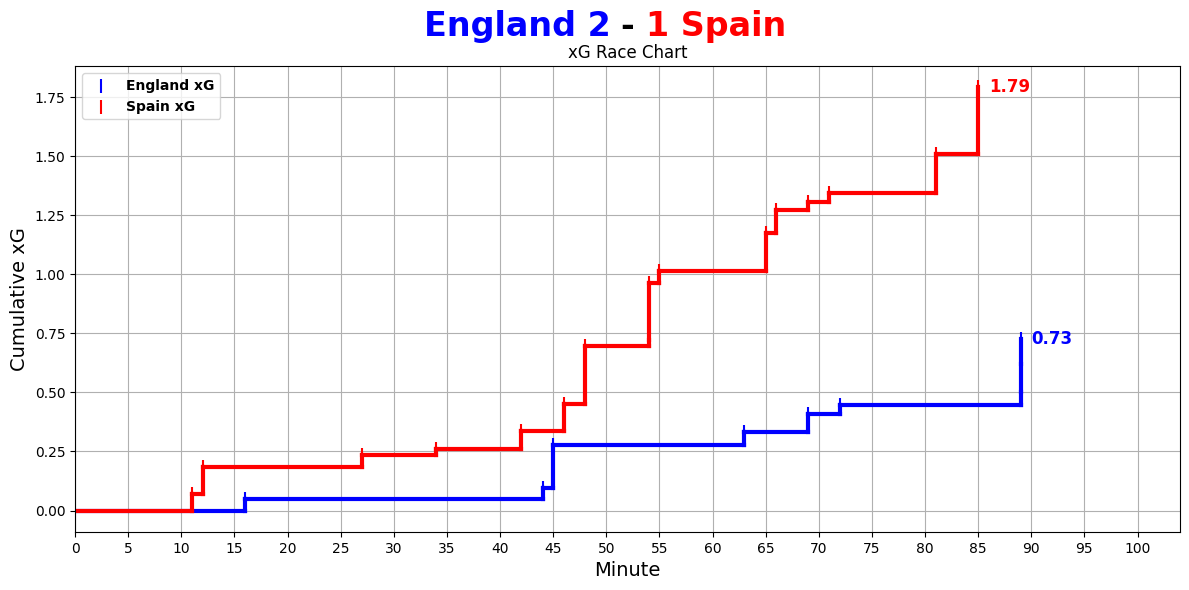

In [310]:
plot_xg_race(df, focus_team, opposition)

In [315]:
# Stat summary

In [650]:
# Possession

def calculate_possession(df, focus_team, opposition):
    # Filter the events for "Pass" type for both teams
    passes = df[df["type_name"] == "Pass"]

    # Count the number of "Pass" events for each team
    focus_team_passes = passes[passes["team_name"] == focus_team]
    opposition_passes = passes[passes["team_name"] == opposition]

    # Count the total number of passes
    total_passes = len(focus_team_passes) + len(opposition_passes)

    # Calculate possession percentages
    focus_team_possession = (len(focus_team_passes) / total_passes) * 100 if total_passes > 0 else 0
    opposition_possession = (len(opposition_passes) / total_passes) * 100 if total_passes > 0 else 0

    return focus_team_possession, opposition_possession

focus_team_possession, opposition_possession = calculate_possession(df, 'Spain', 'England')

print(f"Spain Possession: {focus_team_possession:.2f}%")
print(f"England Possession: {opposition_possession:.2f}%")

Spain Possession: 64.67%
England Possession: 35.33%


In [410]:
# Check Passes In AND Into F3 and Box

In [411]:
def calculate_passes_into_f3_and_box(df, focus_team):
    # Filter the events for "Pass" type for the focus team
    passes = df[(df["type_name"] == "Pass") & (df["team_name"] == focus_team)]
    
    # Filter out passes where the 'type' does not exist in 'pass' data
    passes = passes[passes['pass'].apply(lambda x: 'type' not in x if isinstance(x, dict) else True)]
    
    # Extract x, y for start location from 'location' column
    passes['start_x'] = passes['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    passes['start_y'] = passes['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)
    
    # Extract x, y for end location from 'pass' column
    passes['end_x'] = passes['pass'].apply(lambda x: x['end_location'][0] if isinstance(x, dict) and 'end_location' in x else None)
    passes['end_y'] = passes['pass'].apply(lambda x: x['end_location'][1] if isinstance(x, dict) and 'end_location' in x else None)

    # Filter passes into the Box
    passes_into_box = passes[
        (passes["start_x"] < 102) &  # Starting location x < 102 (before the box)
        (passes["start_y"] < 18) | (passes["start_y"] > 62) &  # Starting location y < 18 or y > 62 (outside the box vertically)
        (passes["end_x"] >= 102) &  # End location x >= 102 (inside the box horizontally)
        (passes["end_y"] >= 18) & (passes["end_y"] <= 62)  # End location y between 18 and 62 (inside the box vertically)
    ]
 
    # Filter passes into the Final Third (F3)
    passes_into_f3 = passes[
        (passes["end_x"] >= 80)  # End location y >= 80 (into final third)
    ]
    
    # Get the count of passes into the box and into the final third
    passes_into_box_count = len(passes_into_box)
    passes_into_f3_count = len(passes_into_f3)
    
    return passes_into_box_count, passes_into_f3_count

In [414]:
passes_into_box_count, passes_into_f3_count = calculate_passes_into_f3_and_box(df, 'Spain')

print(f"Passes into the Box: {passes_into_box_count}")
print(f"Passes into the Final Third: {passes_into_f3_count}")

passes_into_box_count, passes_into_f3_count = calculate_passes_into_f3_and_box(df, 'England')

print(f"Passes into the Box: {passes_into_box_count}")
print(f"Passes into the Final Third: {passes_into_f3_count}")

Passes into the Box: 107
Passes into the Final Third: 159
Passes into the Box: 43
Passes into the Final Third: 78


In [446]:
def count_deep_progressions(df, focus_team):
    # Extract x, y for start location from 'location' column
    df['start_x'] = df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    df['start_y'] = df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    # Extract x, y for end location (Pass or Carry events)
    df['end_x'] = df.apply(lambda row: row['pass']['end_location'][0] if row['type_name'] == "Pass" and isinstance(row.get('pass', {}).get('end_location'), list) else 
                                      (row['carry']['end_location'][0] if row['type_name'] == "Carry" and isinstance(row.get('carry', {}).get('end_location'), list) else None), axis=1)

    df['end_y'] = df.apply(lambda row: row['pass']['end_location'][1] if row['type_name'] == "Pass" and isinstance(row.get('pass', {}).get('end_location'), list) else 
                                      (row['carry']['end_location'][1] if row['type_name'] == "Carry" and isinstance(row.get('carry', {}).get('end_location'), list) else None), axis=1)

    # Filter for Pass or Carry events for the given team
    deep_progressions = df[
        (df["team_name"] == focus_team) &
        (df["type_name"].isin(["Pass", "Carry"])) &  # Only Pass or Carry
        (df["start_x"] < 80) &  # Start before x=80
        (df["end_x"] >= 80)  # End at or beyond x=80
    ]
    
    return len(deep_progressions)

In [447]:
deep_progressions_count = count_deep_progressions(df, 'Spain')

print(f"Deep Progressions Spain: {deep_progressions_count}")

deep_progressions_count = count_deep_progressions(df, 'England')

print(f"Deep Progressions England: {deep_progressions_count}")

Deep Progressions Spain: 67
Deep Progressions England: 49


In [459]:
# Calculate shot metrics

In [488]:
# Filter for shots
shots = df[df["type_name"] == "Shot"].copy()

# Extract the 'name' from the 'play_pattern' dictionary for each shot, if it exists
shots['play_pattern_name'] = shots['play_pattern'].apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else None)

# Filter out None values
shots = shots.dropna(subset=['play_pattern_name'])

# Get the count of each play pattern for each team
play_pattern_counts = shots.groupby(['team_name', 'play_pattern_name']).size().reset_index(name='count')

# Print the counts for each team and play pattern
print(play_pattern_counts)

  team_name play_pattern_name  count
0   England       From Corner      4
1   England    From Free Kick      2
2   England    From Goal Kick      1
3   England       From Keeper      1
4   England      Regular Play      1
5     Spain       From Corner      4
6     Spain      From Counter      2
7     Spain    From Free Kick      2
8     Spain     From Throw In      5
9     Spain      Regular Play      3


In [526]:
def calculate_shot_metrics(df, focus_team):
    # Filter shots
    shots = df[df["type_name"] == "Shot"].copy()

    # Extract xG
    shots['xg'] = shots['shot'].apply(lambda x: x.get('statsbomb_xg', 0) if isinstance(x, dict) else 0)

    # Extract shot location (start_x, start_y)
    shots['start_x'] = shots['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    shots['start_y'] = shots['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None)

    # Extract the 'name' from the 'play_pattern' dictionary for each shot, if it exists
    shots['play_pattern_name'] = shots['play_pattern'].apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else None)

    # Identify set-piece shots (From Corner only)
    set_piece_shots = shots[shots['play_pattern_name'].isin(['From Corner', 'From Free Kick'])]

    # Define Open Play shots as those that are not from set-piece situations
    open_play_shots = shots[~shots['play_pattern_name'].isin(['From Corner', 'From Free Kick'])]

    # Shots inside the box (End X in the penalty area: 102-120, End Y: 18-62)
    shots_inside_box = open_play_shots[
        (open_play_shots["start_x"] >= 102) & (open_play_shots["start_x"] <= 120) &
        (open_play_shots["start_y"] >= 18) & (open_play_shots["start_y"] <= 62)
    ]

    # Calculate shot distance from goal (assuming goal at x=120, y=40)
    shots['shot_distance'] = shots.apply(lambda row: ((120 - row['start_x'])**2 + (40 - row['start_y'])**2)**0.5, axis=1)

    # Filter shots by team
    team_shots = shots[shots["team_name"] == focus_team]
    team_open_play_shots = open_play_shots[open_play_shots["team_name"] == focus_team]
    team_shots_inside_box = shots_inside_box[shots_inside_box["team_name"] == focus_team]
    team_set_piece_shots = set_piece_shots[set_piece_shots["team_name"] == focus_team]

    # Calculate metrics
    total_xg = team_shots["xg"].sum()
    open_play_xg = team_open_play_shots["xg"].sum()
    set_piece_xg = team_set_piece_shots["xg"].sum()  # Set-piece xG
    total_shots = len(team_shots)
    open_play_shots_count = len(team_open_play_shots)
    open_play_shots_inside_box = len(team_shots_inside_box)
    set_piece_shots_count = len(team_set_piece_shots)  # Number of set-piece shots
    xg_per_shot = total_xg / total_shots if total_shots > 0 else 0
    avg_shot_distance = team_shots["shot_distance"].mean()

    # Print results
    print(f"Total xG: {total_xg:.2f}")
    print(f"Open Play xG: {open_play_xg:.2f}")
    print(f"Set Piece xG (From Corner or Free Kick): {set_piece_xg:.2f}")
    print(f"xG per Shot: {xg_per_shot:.2f}")
    print(f"Total Shots: {total_shots}")
    print(f"Total Open Play Shots: {open_play_shots_count}")
    print(f"Set Piece Shots (From Corner or Free Kick): {set_piece_shots_count}")
    print(f"Open Play Shots Inside the Box: {open_play_shots_inside_box}")
    print(f"Average Shot Distance: {avg_shot_distance:.2f} meters")

In [525]:
calculate_shot_metrics(df, "Spain")

Total xG: 1.79
Open Play xG: 1.42
Set Piece xG (From Corner or Free Kick): 0.37
xG per Shot: 0.11
Total Shots: 16
Total Open Play Shots: 10
Set Piece Shots (From Corner): 6
Open Play Shots Inside the Box: 8
Average Shot Distance: 16.84 meters


In [527]:
calculate_shot_metrics(df, "England")

Total xG: 0.73
Open Play xG: 0.16
Set Piece xG (From Corner or Free Kick): 0.57
xG per Shot: 0.08
Total Shots: 9
Total Open Play Shots: 3
Set Piece Shots (From Corner or Free Kick): 6
Open Play Shots Inside the Box: 1
Average Shot Distance: 16.87 meters


In [528]:
# Defensive Metrics 

In [530]:
# Start with PPDA

In [582]:
def calculate_ppda_by_team(df, team_name, opp_name):
    # Initialize an empty dictionary to store the PPDA results for the specified teams
    ppda_results = {}

    # Filter the dataframe for the current team (team_name) and the opponent (opp_name)
    team_df = df[df['team_name'] == team_name].copy()
    
    # Filter for completed passes with start_location_x < 72 (for the opposition)
    completed_passes = df[
        (df['team_name'] == opp_name) &  # Get the passes from the opponent
        (df['type_name'] == 'Pass') &  # Filter for passes
        (df['location'].apply(lambda loc: loc[0] < 72 if isinstance(loc, list) else False))  # Passes starting in own half
    ]

    # Filter for defensive actions (tackle, interception, dribbled past, or foul) only for the team
    defensive_actions = team_df[
        (
            (team_df['type_name'] == 'Duel') & 
            (team_df['duel'].apply(lambda x: x.get('type', {}).get('name') == 'Tackle' if isinstance(x, dict) else False)) |
            (team_df['type_name'] == 'Interception') |
            ((team_df['type_name'] == 'Pass') & 
             (team_df['pass'].apply(lambda x: x.get('type', {}).get('name') == 'Interception' if isinstance(x, dict) else False))) |
            (team_df['type_name'] == 'Dribbled Past') |
            (team_df['type_name'] == 'Foul Committed')
        )
    ]

    # Further filter defensive actions where event_x >= 48 (opponent's half)
    defensive_actions = defensive_actions[
        defensive_actions['location'].apply(lambda loc: loc[0] >= 48 if isinstance(loc, list) else False)
    ]

    # Calculate the counts for completed passes and defensive actions
    completed_passes_count = len(completed_passes)
    defensive_actions_count = len(defensive_actions)

    # Calculate PPDA for the team (ensure no division by zero)
    ppda = completed_passes_count / defensive_actions_count if defensive_actions_count > 0 else 0

    # Store the result in the dictionary
    ppda_results[team_name] = {
        'Completed Passes (Opposition)': completed_passes_count,
        'Defensive Actions (Team)': defensive_actions_count,
        'PPDA': ppda
    }

    # Return the PPDA results for the specified team
    return ppda_results

In [583]:
calculate_ppda_by_team(df, 'Spain', 'England')

{'Spain': {'Completed Passes (Opposition)': 228,
  'Defensive Actions (Team)': 23,
  'PPDA': 9.91304347826087}}

In [584]:
calculate_ppda_by_team(df, 'England', 'Spain')

{'England': {'Completed Passes (Opposition)': 377,
  'Defensive Actions (Team)': 22,
  'PPDA': 17.136363636363637}}

In [586]:
# Pressure Stats
# Pressures, Pressure Regains, Possession Adjusted Pressures, CP Regains

In [635]:
def calculate_pressures_and_regains_by_team(df):
    # Initialize an empty dictionary to store pressures and pressure regains for each team
    team_stats = {}

    # Loop through each unique team in the dataframe
    for team in df['team_name'].unique():
        pressures_count = 0
        pressure_regains_count = 0
        
        # Filter the dataframe for Pressure events for the current team
        pressure_events = df[(df['type_name'] == 'Pressure') & (df['team_name'] == team)]
        
        # Loop through each Pressure event
        for index, pressure_event in pressure_events.iterrows():
            pressures_count += 1  # Increment the count of Pressures
            
            # Get the current pressure event details
            pressure_duration = pressure_event['duration']
            pressure_team = pressure_event['team_name']
            pressure_event_time = pressure_event['timestamp']  # Assuming timestamp exists
            pressure_period = pressure_event['period']  # Assuming period exists
            
            # Check if the pressure event occurred in the last 5 seconds of possession
            if pressure_duration < 5:
                # Find the next event after the pressure event, within the same period
                subsequent_events = df[
                    (df['timestamp'] > pressure_event_time) & 
                    (df['period'] == pressure_period)
                ]
                
                # Check if there is any subsequent event after this pressure event
                if not subsequent_events.empty:
                    # Get the first subsequent event
                    subsequent_event = subsequent_events.iloc[0]
                    
                    # Check if the possession team has changed to the team that made the pressure
                    if subsequent_event['team_name'] == pressure_team:
                        pressure_regains_count += 1
        
        # Store the result for the current team
        team_stats[team] = {
            'Pressures': pressures_count,
            'Pressure Regains': pressure_regains_count
        }

    return team_stats

In [636]:
calculate_pressures_and_regains_by_team(df)

{'Spain': {'Pressures': 161, 'Pressure Regains': 26},
 'England': {'Pressures': 166, 'Pressure Regains': 19}}

In [691]:
# Function to calculate PAdj Pressures
def calculate_padj_pressures(df, focus_team, opposition_team):
    # Get possession for both teams
    focus_team_possession, opposition_possession = calculate_possession(df, focus_team, opposition_team)

    # Convert possession to percentage
    focus_team_possession_percent = focus_team_possession / 100
    opposition_possession_percent = opposition_possession / 100

    # Calculate pressure count for the focus team
    focus_team_pressure_count = len(df[(df['team_name'] == focus_team) & (df['type_name'] == 'Pressure')])

    # Calculate PAdj Pressures for the focus team using the possession formula
    padj_focus_team = (focus_team_pressure_count * 2) / (1 + np.exp(-10 * (focus_team_possession_percent - 0.5)))

    # Now swap teams and calculate for the opposition team
    opposition_focus_team_possession, opposition_opposition_possession = calculate_possession(df, opposition_team, focus_team)
    
    # Convert possession to percentage for the opposition
    opposition_focus_team_possession_percent = opposition_focus_team_possession * 100

    # Calculate pressure count for the opposition team
    opposition_pressure_count = len(df[(df['team_name'] == opposition_team) & (df['type_name'] == 'Pressure')])

    # Calculate PAdj Pressures for the opposition team using the possession formula
    padj_opposition_team = (opposition_pressure_count * 2) / (1 + np.exp(-0.1 * (opposition_focus_team_possession_percent - 50)))

    return {
        'Focus Team': focus_team,
        'Focus Team Pressure Count': focus_team_pressure_count,
        'Focus Team PAdj Pressures': padj_focus_team,
        'Opposition Team': opposition_team,
        'Opposition Pressure Count': opposition_pressure_count,
        'Opposition PAdj Pressures': padj_opposition_team
    }

In [692]:
focus_team = 'Spain'
opposition_team = 'England'

padj_pressures = calculate_padj_pressures(df, focus_team, opposition_team)

# Print the results
print(f"Focus Team: {padj_pressures['Focus Team']}")
print(f"Focus Team Pressure Count: {padj_pressures['Focus Team Pressure Count']}")
print(f"Focus Team PAdj Pressures: {padj_pressures['Focus Team PAdj Pressures']}")

Focus Team: Spain
Focus Team Pressure Count: 161
Focus Team PAdj Pressures: 261.64473215650605


In [690]:
focus_team = 'England'
opposition_team = 'Spain'

padj_pressures = calculate_padj_pressures(df, focus_team, opposition_team)

# Print the results
print(f"Focus Team: {padj_pressures['Focus Team']}")
print(f"Focus Team Pressure Count: {padj_pressures['Focus Team Pressure Count']}")
print(f"Focus Team PAdj Pressures: {padj_pressures['Focus Team PAdj Pressures']}")

Focus Team: England
Focus Team Pressure Count: 166
Focus Team PAdj Pressures: 62.22965504360239


In [702]:
def calculate_counterpressures_and_regains_by_team(df):
    # Initialize an empty dictionary to store counterpressures and counterpressure regains for each team
    team_stats = {}

    # Loop through each unique team in the dataframe
    for team in df['team_name'].unique():
        counterpressures_count = 0
        counterpressure_regains_count = 0
        
        # Filter the dataframe for Counterpress events for the current team
        counterpress_events = df[(df['counterpress'].notna()) & (df['team_name'] == team)]
        
        # Loop through each Counterpress event
        for index, counterpress_event in counterpress_events.iterrows():
            counterpressures_count += 1  # Increment the count of Counterpressures
            
            # Get the current counterpress event details
            counterpress_duration = counterpress_event['duration']
            counterpress_team = counterpress_event['team_name']
            counterpress_event_time = counterpress_event['timestamp']  # Assuming timestamp exists
            counterpress_period = counterpress_event['period']  # Assuming period exists
            
            # Check if the counterpress event occurred in the last 5 seconds of possession
            if counterpress_duration < 5:
                # Find the next event after the counterpress event, within the same period
                subsequent_events = df[
                    (df['timestamp'] > counterpress_event_time) & 
                    (df['period'] == counterpress_period)
                ]
                
                # Check if there is any subsequent event after this counterpress event
                if not subsequent_events.empty:
                    # Get the first subsequent event
                    subsequent_event = subsequent_events.iloc[0]
                    
                    # Check if the possession team has changed to the team that made the counterpress
                    if subsequent_event['team_name'] == counterpress_team:
                        counterpressure_regains_count += 1
        
        # Store the result for the current team
        team_stats[team] = {
            'Counterpressures': counterpressures_count,
            'Counterpressure Regains': counterpressure_regains_count
        }

    return team_stats

In [703]:
counterpress_stats = calculate_counterpressures_and_regains_by_team(df)
print(counterpress_stats)

{'Spain': {'Counterpressures': 51, 'Counterpressure Regains': 19}, 'England': {'Counterpressures': 43, 'Counterpressure Regains': 17}}


In [706]:
# Ball Recoveries in Opp Half

In [708]:
def calculate_ball_recoveries_in_opp_half(df, focus_team):
    # Filter for Ball Recovery events for the given team
    ball_recoveries = df[(df["type_name"] == "Ball Recovery") & (df["team_name"] == focus_team)]
    
    # Filter out events where 'location' is not a valid list or does not have 'x' value
    ball_recoveries = ball_recoveries[ball_recoveries['location'].apply(lambda loc: isinstance(loc, list) and len(loc) > 0)]
    
    # Extract x and y coordinates for the location
    ball_recoveries['x'] = ball_recoveries['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None)
    
    # Filter to only include recoveries that happened in the opposition's half (x > 60)
    ball_recoveries_in_opp_half = ball_recoveries[ball_recoveries['x'] > 60]
    
    # Return the count of Ball Recoveries in the opposition's half
    return len(ball_recoveries_in_opp_half)

In [709]:
focus_team = "Spain"
ball_recoveries_in_opp_half = calculate_ball_recoveries_in_opp_half(df, focus_team)
print(f"Ball Recoveries in Opposition Half for {focus_team}: {ball_recoveries_in_opp_half}")

Ball Recoveries in Opposition Half for Spain: 16


In [710]:
focus_team = "England"
ball_recoveries_in_opp_half = calculate_ball_recoveries_in_opp_half(df, focus_team)
print(f"Ball Recoveries in Opposition Half for {focus_team}: {ball_recoveries_in_opp_half}")

Ball Recoveries in Opposition Half for England: 21


In [711]:
# PPDA Per 15 mins

In [791]:
from matplotlib.patches import ConnectionPatch
def calculate_ppda_for_game(df, opp_name):
    # Helper function to calculate PPDA for a given period
    def ppda_for_period(events, opp_name):
        passes = events[(events['type_name'] == 'Pass') &
                        (events['location'].apply(lambda loc: isinstance(loc, list) and loc[0] < 72.73)) &
                        (events['team_name'] != opp_name)]
        passes_count = len(passes)
        
        defensive_actions = events[
            (
                (events['type_name'] == 'Duel') & 
                (events['duel'].apply(lambda x: x.get('type', {}).get('name') == 'Tackle' if isinstance(x, dict) else False)) |
                (events['type_name'] == 'Interception') |
                ((events['type_name'] == 'Pass') & 
                 (events['pass'].apply(lambda x: x.get('type', {}).get('name') == 'Interception' if isinstance(x, dict) else False))) |
                (events['type_name'] == 'Dribbled Past') |
                (events['type_name'] == 'Foul Committed')
            )
        ]


        defensive_actions = defensive_actions[defensive_actions['location'].apply(lambda loc: isinstance(loc, list) and loc[0] >= 47.27)]
        defensive_actions_count = len(defensive_actions)

        if defensive_actions_count == 0:
            return 0  # Return 0 if no defensive actions

        ppda = passes_count / defensive_actions_count
        return ppda

    # Use df['minute'] directly for total minutes
    df['interval_category'] = np.select(
        [
            (df['minute'] < 15),
            (df['minute'] >= 15) & (df['minute'] < 30),
            (df['minute'] >= 30) & (df['minute'] < 45),
            ((df['minute'] >= 45) & (df['minute'] < 60) & (df['period'] == 1)),
            ((df['minute'] >= 45) & (df['minute'] < 60) & (df['period'] == 2)),
            ((df['minute'] >= 60) & (df['minute'] < 75)),
            ((df['minute'] >= 75))
        ],
        [
            '0-15', '15-30', '30-45', '30-45', '45-60', '60-75', '75-90'
        ])

    ppda_dict = []

    # Calculate PPDA for each interval category
    for interval_category in ['0-15', '15-30', '30-45', '45-60', '60-75', '75-90']:
        interval_events = df[df['interval_category'] == interval_category]
        ppda = ppda_for_period(interval_events, opp_name)
        ppda_dict.append(ppda)

    # Calculate the averages for each interval
    interval_averages = np.mean(ppda_dict)

    # Calculate the average for the first and second halves
    first_half_avg_values = [ppda_dict[i] for i in range(3) if ppda_dict[i] != float('inf')]
    second_half_avg_values = [ppda_dict[i] for i in range(3, 6) if ppda_dict[i] != float('inf')]
    
    first_half_average = np.mean(first_half_avg_values) if first_half_avg_values else 0
    second_half_average = np.mean(second_half_avg_values) if second_half_avg_values else 0

    return {
        "ppda_per_15_min": ppda_dict,
        "interval_averages": interval_averages,
        "first_half_average": first_half_average,
        "second_half_average": second_half_average
    }


def plot_ppda_averages(averages, opp_name, save_dir):
    intervals = ['0-15', '15-30', '30-45', '45-60', '60-75', '75-90']
    interval_averages = averages['ppda_per_15_min']
    first_half_avg = averages['first_half_average']
    second_half_avg = averages['second_half_average']

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot PPDA for each 15-minute interval
    ax.plot(intervals, interval_averages[::-1], marker='o', label='PPDA per 15 min', linewidth=2.5)
    plt.gca().invert_yaxis()

    # Plot the first and second half averages
    ax.axhline(y=first_half_avg, color='black', linestyle='--', label='First Half Average', linewidth=2)
    ax.axhline(y=second_half_avg, color='black', linestyle='--', label='Second Half Average', linewidth=2)

    # Annotate the averages
    ax.text(2.5, first_half_avg - 0.05, f'Second Half Avg: {first_half_avg:.2f}', color='black', ha='center', fontsize=12, weight='bold')
    ax.text(4.5, second_half_avg - 0.05, f'First Half Avg: {second_half_avg:.2f}', color='black', ha='center', fontsize=12, weight='bold')

    ax.set_xlabel('Time Interval (minutes)', fontsize=14, weight='bold')
    ax.set_ylabel('PPDA', fontsize=14, weight='bold')

    # Remove grid lines
    ax.grid(False)

    # Set titles
    fig.text(s=f"{opp_name}: PPDA Analysis",
             x=0.33, y=1.05, fontsize=22, color="black", fontweight='semibold')

    # Add arrow with text
    left_arrow = dict(facecolor='black', arrowstyle='->')
    right_arrow = dict(facecolor='black', arrowstyle='->')
    con = ConnectionPatch(xyA=(0.97, 0.8), xyB=(0.97, 0.1), coordsA="figure fraction", coordsB="figure fraction",
                          axesA=fig.axes[0], axesB=fig.axes[0], **right_arrow)
    fig.add_artist(con)

    fig.text(s=f"Bad", x=1, y=0.1, ha='center', fontsize=12, color='Red')
    fig.text(s=f"Good", x=1, y=0.8, ha='center', fontsize=12, color='Green')

    # Define the directory and file path
    save_path = os.path.join(save_dir, f"{opp_name}_PPDA_Analysis.png")
    
    # Save the plot as a PNG file
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()

In [792]:
averages = calculate_ppda_for_game(df, 'Spain')

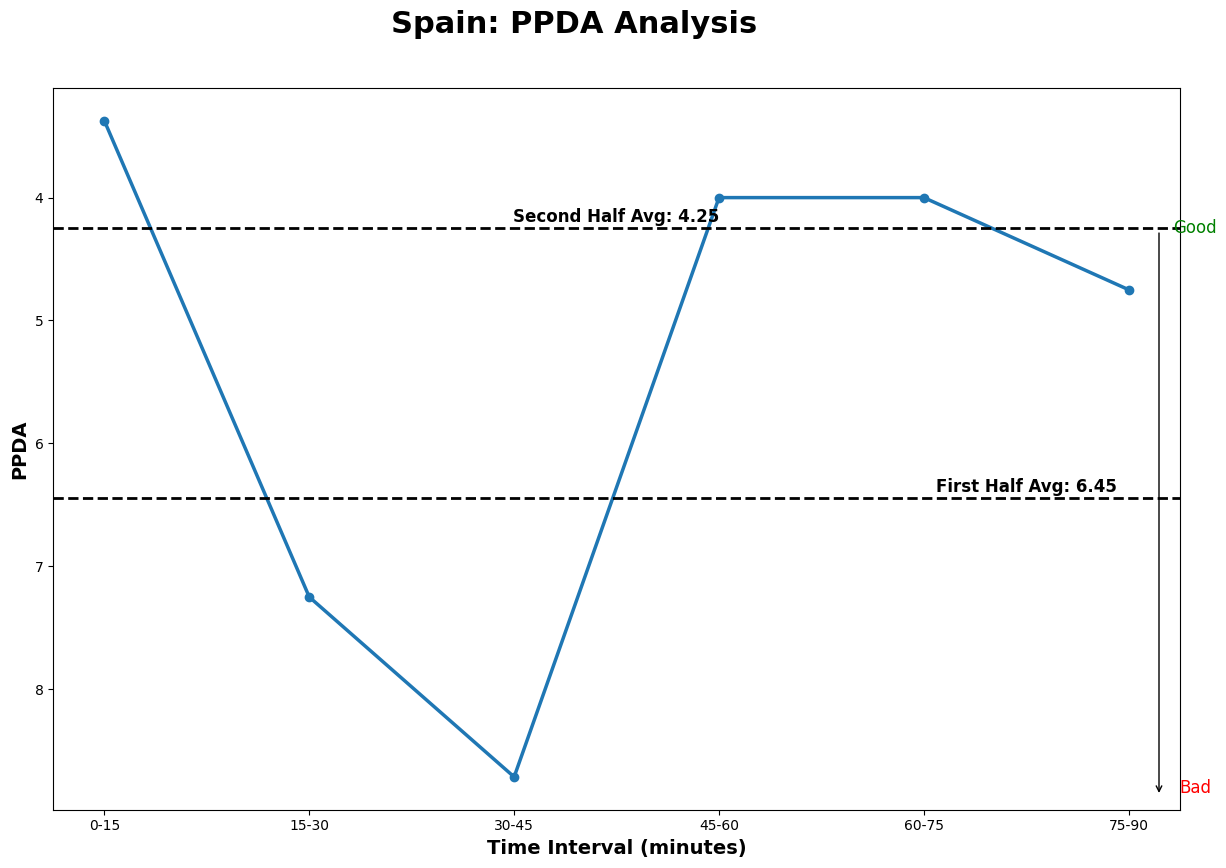

In [793]:
plot_ppda_averages(averages, 'Spain', '/Users/andreasbancheri/Documents/Tottenham')

In [794]:
averages = calculate_ppda_for_game(df, 'England')

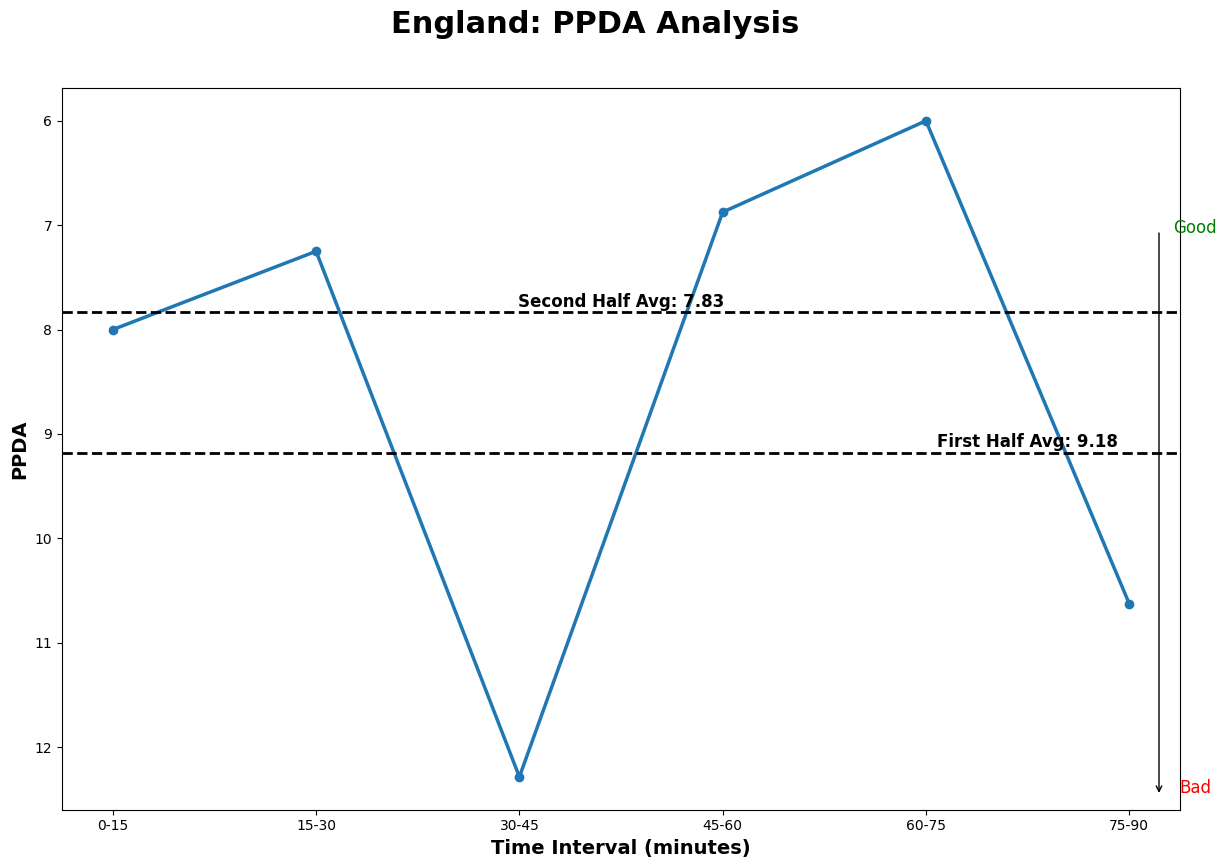

In [795]:
plot_ppda_averages(averages, 'England', '/Users/andreasbancheri/Documents/Tottenham')

In [983]:
# Plot Pass Network

In [843]:
def add_arrow(x1, y1, x2, y2, ax, color, alpha, lw):
    """
    Add an arrow to the plot.
    """
    arrowprops = dict(facecolor=color, edgecolor=color, alpha=alpha, lw=lw, arrowstyle='->')
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=arrowprops)

In [1010]:
def plot_pass_network_intervals(match_events, opp_name, save_dir,
                                min_pass_count=4, arrow_shift=4, cmap_name='Blues',
                                players_to_exclude=None):
    # Ensure players_to_exclude is a dictionary
    if players_to_exclude is None:
        players_to_exclude = {}

    # Extract the two Starting XI rows
    starting_xi = df[df['type_name'] == 'Starting XI']
    
    # Ensure there are at least two rows for both teams
    if len(starting_xi) < 2:
        raise ValueError("Not enough Starting XI data found.")
    
    # Get team names
    team_1_name = starting_xi.iloc[0]['team_name']
    team_2_name = starting_xi.iloc[1]['team_name']
    
    # Extract lineups, ensuring 'tactics' and 'lineup' exist
    team_1_lineup = starting_xi.iloc[0].get('tactics', {}).get('lineup', [])
    team_2_lineup = starting_xi.iloc[1].get('tactics', {}).get('lineup', [])
    
    # Check if lineups are valid
    if not team_1_lineup or not team_2_lineup:
        raise ValueError("One or both teams are missing lineup data.")

    # Combine both teams into full_match_players list
    full_match_players = [
        {'team': team_1_name, 'player': p['player']['name'], 'position': p['position']['name'], 'jersey_number': p.get('jersey_number', None)}
        for p in team_1_lineup
    ] + [
        {'team': team_2_name, 'player': p['player']['name'], 'position': p['position']['name'], 'jersey_number': p.get('jersey_number', None)}
        for p in team_2_lineup
    ]
    
    # Output only player names if needed
    full_match_players = [p['player'] for p in full_match_players]
    
    # Filter to only include events from the opponent team
    match_events = match_events[match_events['team_name'] == opp_name]

    # Iterate through each 15-minute interval
    interval_pass_networks = {}
    
    for interval, interval_df in match_events.groupby('interval_category'):
        # Filter passes only
        passes = interval_df[interval_df['type_name'] == 'Pass'].copy()
    
        # Extract pass recipient names
        passes['pass_recipient'] = passes['pass'].apply(lambda x: x.get('recipient', {}).get('name') if isinstance(x, dict) else None)
    
        # Compute pass networks for each interval
        player_location_df = passes.groupby(['player_name']).agg(
            x=('x', 'mean'), 
            y=('y', 'mean'),
            total=('x', 'size')
        ).reset_index()
    
        players_passes_df = passes.groupby(['player_name', 'pass_recipient']).agg(
            passes=('x', 'size')
        ).reset_index()
    
        # Merge passer's location
        players_passes_df = players_passes_df.merge(player_location_df[['player_name', 'x', 'y']], 
                                                    left_on='player_name', right_on='player_name').\
                                                rename(columns={'x': 'passer_x', 
                                                                'y': 'passer_y'})
    
        # Merge recipient's location
        players_passes_df = players_passes_df.merge(player_location_df[['player_name', 'x', 'y']], 
                                                    left_on='pass_recipient', right_on='player_name',
                                                    suffixes=('', '_recipient'))
    
        # Rename recipient columns
        players_passes_df.rename(columns={'x': 'recipient_x', 'y': 'recipient_y'}, inplace=True)
    
        # Drop redundant 'player_name' column from recipient merge
        players_passes_df.drop(columns=['player_name_recipient'], inplace=True)
    
        # Sort by number of passes
        players_passes_df.sort_values("passes", ascending=True, inplace=True)
    
        # Store the pass network DataFrame in the dictionary with interval as key
        interval_pass_networks[interval] = players_passes_df

    # Dictionaries to store season averages for each interval
    season_player_location_by_interval = {}
    season_players_passes_by_interval = {}
    
    # Compute season averages for each interval
    for interval, pass_network_df in interval_pass_networks.items():
        # Compute season averages for player locations and pass counts
        season_player_location_df = pass_network_df.groupby(['player_name']).agg(
            x_avg=('passer_x', 'mean'),
            y_avg=('passer_y', 'mean'),
            total_avg=('passes', 'mean')  # Using 'passes' for the total pass count
        ).reset_index()
    
        season_players_passes_df = pass_network_df.groupby(['player_name', 'pass_recipient']).agg(
            passes_avg=('passes', 'mean')
        ).reset_index()
    
        # Store the computed DataFrames in dictionaries
        season_player_location_by_interval[interval] = season_player_location_df
        season_players_passes_by_interval[interval] = season_players_passes_df

    # Constants
    MIN_PASS_COUNT = min_pass_count
    ARROW_SHIFT = arrow_shift
    cmap_name = cmap_name
    color = 'red'

    pitch = VerticalPitch(half=False, line_color='black', line_zorder=2, pitch_color='white')
    fig, axs = pitch.grid(nrows=2, ncols=3, figheight=20,
                          axis=False,
                          title_space=0.00, title_height=0.0, grid_height=0.9)

    # Define the colormap
    cmap = plt.cm.get_cmap(cmap_name)

    # Iterate through each interval and corresponding axis
    for i, (interval, ax) in enumerate(zip(season_player_location_by_interval.keys(), axs['pitch'].flat)):
        # Get the data for the current interval
        player_location_df = season_player_location_by_interval[interval]
        players_passes_df = season_players_passes_by_interval[interval]
    
        # Merge data to get all useful columns in a single dataframe
        players_passes_df = players_passes_df.merge(
            player_location_df[['player_name', 'x_avg', 'y_avg']], 
            left_on='player_name', right_on='player_name'
        ).rename(columns={'x_avg': 'passer_x', 'y_avg': 'passer_y'})
    
        players_passes_df = players_passes_df.merge(
            player_location_df[['player_name', 'x_avg', 'y_avg']], 
            left_on='pass_recipient', right_on='player_name'
        ).rename(columns={'x_avg': 'recipient_x', 'y_avg': 'recipient_y'})
    
        players_passes_df.sort_values("passes_avg", ascending=True, inplace=True)
    
        highest_passes = players_passes_df['passes_avg'].max()
        players_passes_df['passes_scaled'] = players_passes_df['passes_avg'] / highest_passes
        
        annotations = []
        for row in players_passes_df.itertuples():
            if row.passes_avg > MIN_PASS_COUNT:  # Check if the pass count is greater than the minimum threshold
                if abs(row.recipient_y - row.passer_y) > abs(row.recipient_x - row.passer_x):  # Compare y and x
                    if row.player_name_x > row.pass_recipient:  # Use the correct column names for player names
                        x_shift, y_shift = 0, ARROW_SHIFT
                    else:
                        x_shift, y_shift = 0, -ARROW_SHIFT
                else:
                    if row.player_name_x > row.pass_recipient:  # Use the correct column names for player names
                        x_shift, y_shift = ARROW_SHIFT, 0
                    else:
                        x_shift, y_shift = -ARROW_SHIFT, 0
        
                arrow = add_arrow(x1=row.recipient_y + y_shift, 
                                  y1=row.recipient_x + x_shift,
                                  x2=row.passer_y + y_shift, 
                                  y2=row.passer_x + x_shift,
                                  ax=ax, 
                                  color=cmap(row.passes_scaled), 
                                  alpha=row.passes_scaled,
                                  lw=row.passes_scaled * 2)
                annotations.append(arrow)

    
        # Plot player locations and names
        player_location_df.sort_values("total_avg", ascending=True, inplace=True)
        
        # Adjust alpha for substitutes based on whether they played in the interval
        for row in player_location_df.itertuples():
            # If the player's name is in the exclude list and the current interval is in the list of intervals to exclude, skip plotting this player
            if row.player_name in players_to_exclude and interval in players_to_exclude[row.player_name]:
                continue  # Skip this player in the current interval
            
            scatter = ax.scatter(row.y_avg, row.x_avg, 
                                 s=(row.total_avg / player_location_df['total_avg'].max()) * 700,
                                 color=color, alpha=1.0, edgecolor='black', linewidth=1.5)
        
            # Label player names
            ax.annotate(row.player_name, (row.y_avg, row.x_avg), fontsize=10, ha='center', va='center', color='black')
    
        # Set titles
        ax.set_title(f"Interval {interval}", fontsize=16, color="black", fontweight='semibold')

    # Set main title
    fig.suptitle(f"{opp_name}: Passing Network", fontsize=34, color="black", fontweight='semibold', y=1.08)
    
    fig.text(s=f"Darker color of arrow indicates higher number of passes in that direction.",  # ha='center'
             x=0.3, y=1.03, fontsize=18, color="black")
    fig.text(s=f"Size indicates total passes made by player. Player needs a touch to appear, may show less than 11 players.",  # ha='center'
             x=0.3, y=1.02, fontsize=18, color="black")
    fig.text(s=f"Minimum {min_pass_count} passes for arrow to show.",  # ha='center'
             x=0.3, y=1.01, fontsize=18, color="black")
    
    # Adjust layout
    fig.tight_layout()

    # Define the directory and file path
    save_path = os.path.join(save_dir, f"{opp_name}_PassNetwork_Intervals.png")
    
    # Save the plot as a PNG file
    fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

/var/folders/xk/7vjjj5j13b5gmh6051l64j5h0000gn/T/ipykernel_25862/2490481601.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


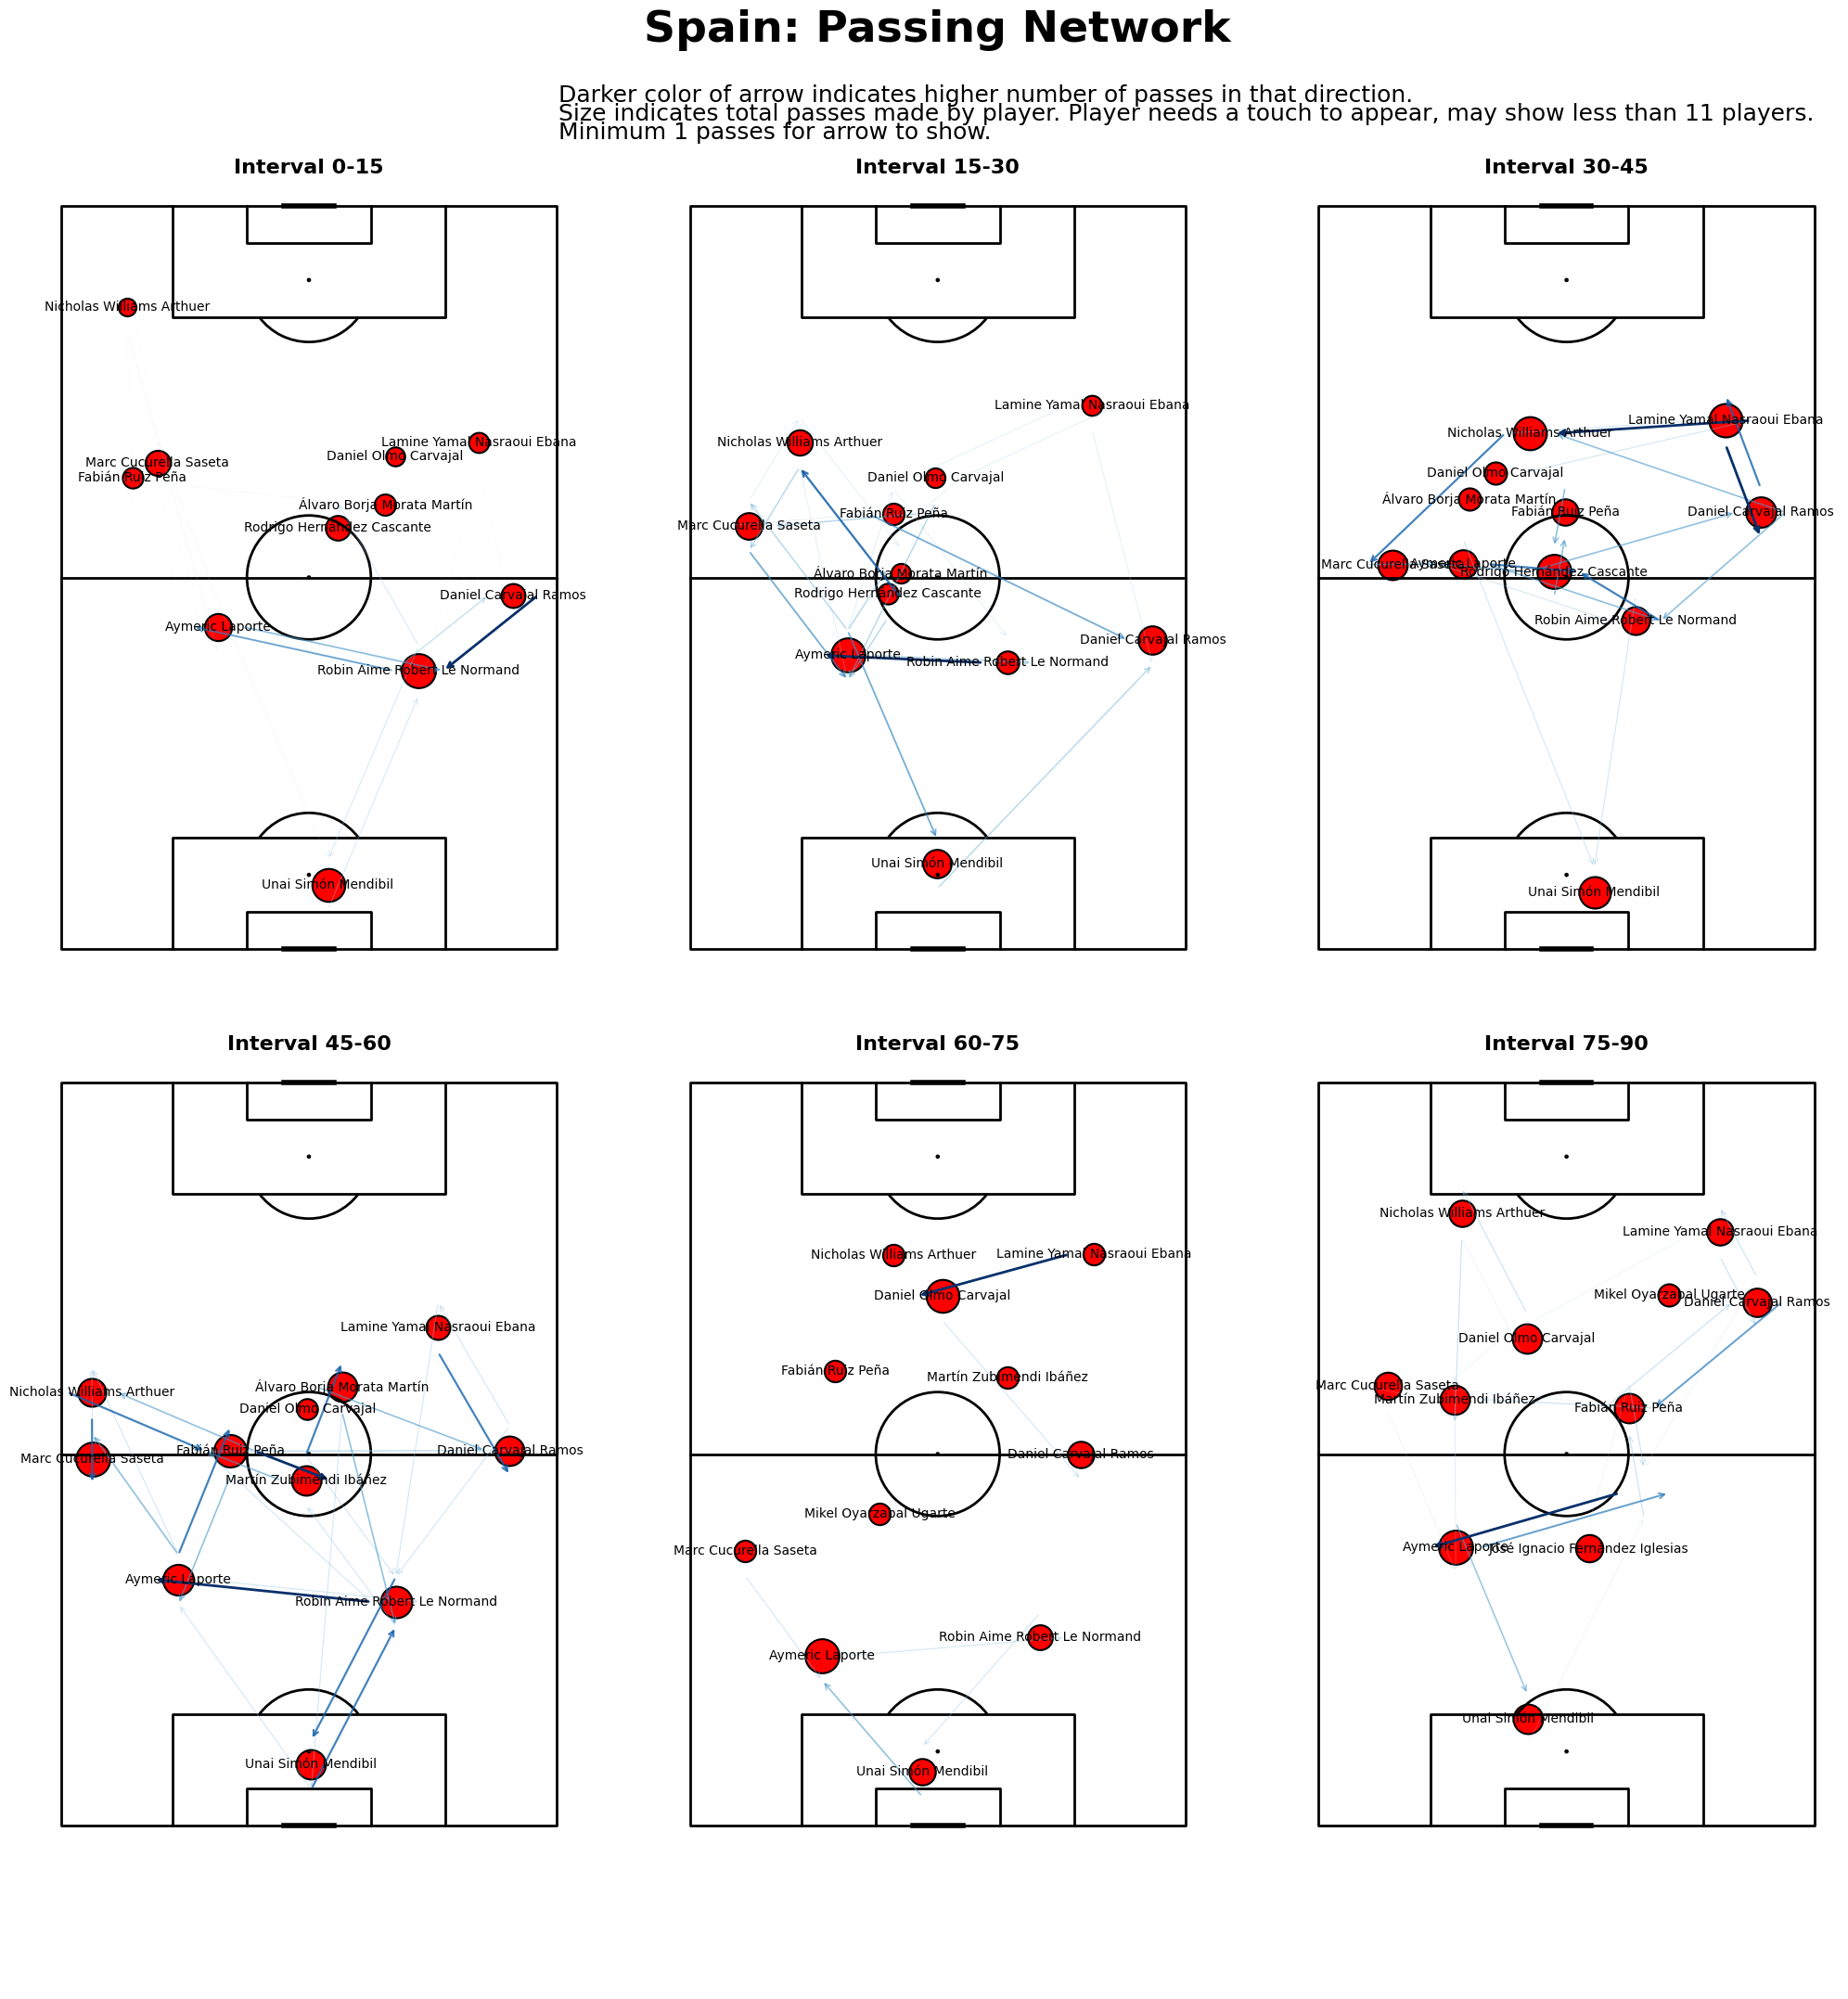

In [1011]:
plot_pass_network_intervals(
    df, 
    opp_name='Spain',  
    save_dir=save_dir, 
    min_pass_count=1, 
    arrow_shift=4, 
    cmap_name='Blues',
    players_to_exclude={
        'Rodrigo Hernández Cascante': ['60-75', '75-90'],  
        'Álvaro Borja Morata Martín': ['60-75', '75-90'],
        'Robin Aime Robert Le Normand': ['75-90']
    }
)

/var/folders/xk/7vjjj5j13b5gmh6051l64j5h0000gn/T/ipykernel_25862/2490481601.py:119: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


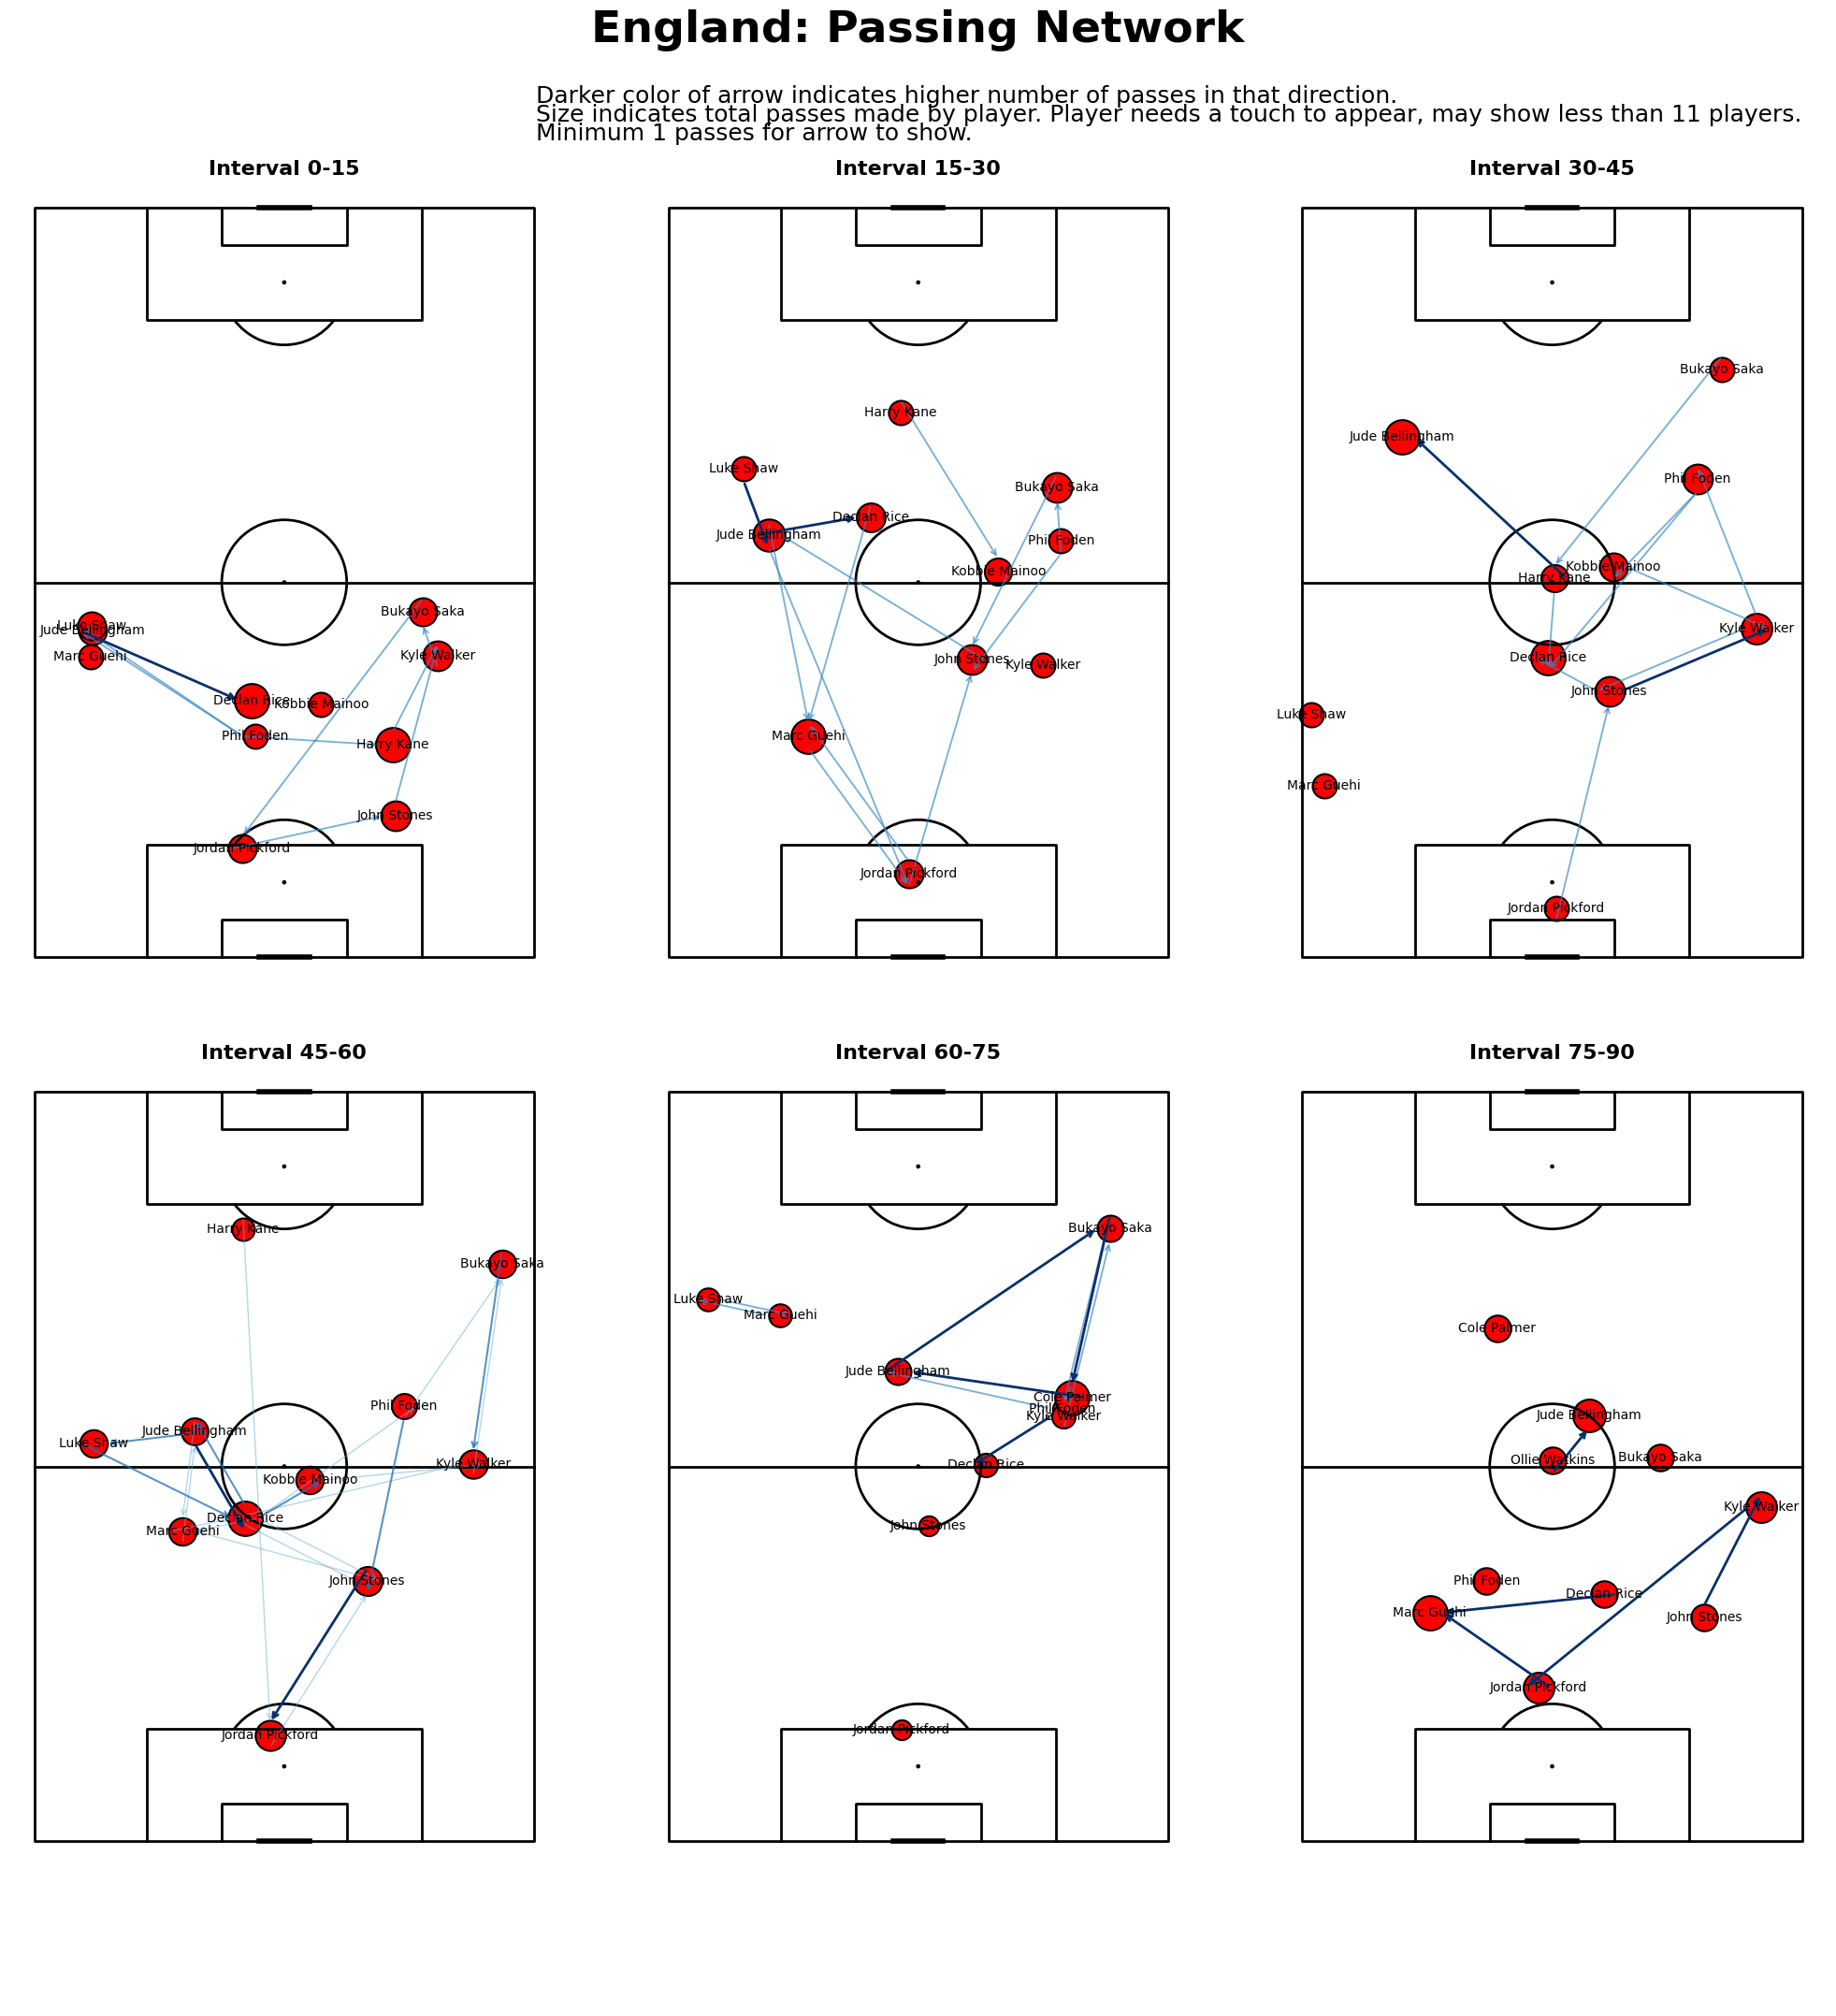

In [1013]:
plot_pass_network_intervals(
    df, 
    opp_name='England',  
    save_dir=save_dir, 
    min_pass_count=1, 
    arrow_shift=2, 
    cmap_name='Blues',
    players_to_exclude={
        'Harry Kane': ['75-90'] 
    }
)

2025-03-31 11:41:41.427 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 11:41:41.428 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 11:41:42.223 
  command:

    streamlit run /Users/andreasbancheri/anaconda3/envs/barnsley/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-31 11:41:42.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 11:41:42.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 11:41:42.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 11:41:42.224 Thread 'MainThread': missing ScriptRunContext! This

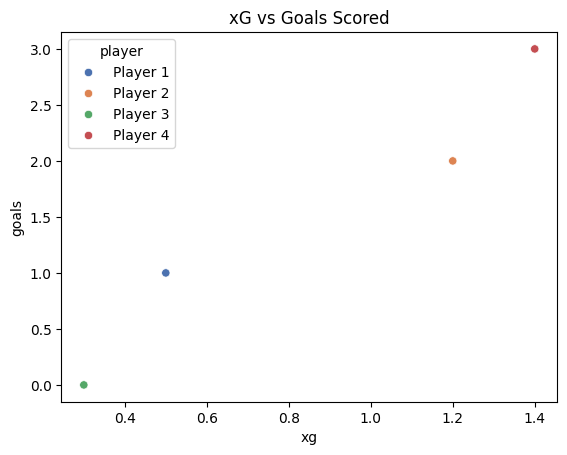

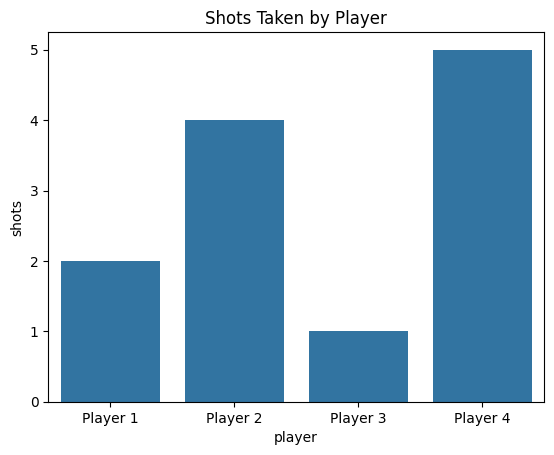

In [1016]:
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set page configuration
st.set_page_config(page_title="Football Dashboard", layout="wide")

# Example data
data = pd.DataFrame({
    'player': ['Player 1', 'Player 2', 'Player 3', 'Player 4'],
    'xg': [0.5, 1.2, 0.3, 1.4],
    'goals': [1, 2, 0, 3],
    'shots': [2, 4, 1, 5]
})

# Sidebar for interactive selection
st.sidebar.header("Dashboard Controls")

# Select player
player_name = st.sidebar.selectbox("Select Player", data['player'])

# Show selected player info
selected_player_data = data[data['player'] == player_name].iloc[0]
st.write(f"### {player_name} - Stats")
st.write(f"Expected Goals (xG): {selected_player_data['xg']}")
st.write(f"Goals Scored: {selected_player_data['goals']}")
st.write(f"Shots Taken: {selected_player_data['shots']}")

# Plot for xG vs Goals Scored
fig, ax = plt.subplots()
sns.scatterplot(x=data['xg'], y=data['goals'], ax=ax, hue=data['player'], palette='deep')
ax.set_title("xG vs Goals Scored")
st.pyplot(fig)

# Plot for Shots Taken
fig, ax = plt.subplots()
sns.barplot(x=data['player'], y=data['shots'], ax=ax)
ax.set_title("Shots Taken by Player")
st.pyplot(fig)

# Display more stats or data as needed
st.write("### More Stats")
st.write(data)